In [2]:
from functions import *
import pickle 
import re
import gc

In [3]:
XLA_PYTHON_CLIENT_MEM_FRACTION=0.5

In [4]:
save_folder = '/mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240607/'

In [5]:
jax.config.update("jax_enable_x64", True)

In [8]:
def load_polymer_simulation(polymer_directory, num_monomers=None):
    items = os.listdir(polymer_directory)
    # Filter out the items that are not directories
    folders = [item for item in items if os.path.isdir(os.path.join(polymer_directory, item))]
    polymer_folders = [os.path.join(polymer_directory, f) for f in folders if f[:8] == 'template']

    def load_polymer_hdf5(polymer_directory, num_monomers):
        URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
        if num_monomers is None:
            [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
        num_polymers = len(URIs)
        polys = np.full((num_monomers, 3, num_polymers), np.nan)
        dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
        for iURI, URI in enumerate(URIs):
            data = polychrom.hdf5_format.load_URI(URI)
            xyz = data["pos"]
            polys[:, :, iURI] = xyz[:num_monomers, :]
            dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
        return polys, dmaps

    polymer_folders.sort()

    polys_list, dmaps_list = [], []
    for f in polymer_folders:
        polys, dmaps = load_polymer_hdf5(f, num_monomers)
        polys_list.append(polys)
        dmaps_list.append(dmaps)
    
    polys_tensor = np.concatenate(polys_list, axis=2)
    dmaps_tensor = np.concatenate(dmaps_list, axis=2)
    
    return polys_tensor, dmaps_tensor 

In [48]:
sarw_directory = r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/SARW'
le_directory = r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_NoBE'
hox_directory =  r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA/'
num_monomers = 100 # 333 monomers are too large - use too much memory

sarw_polys, sarw_dmaps = load_polymer_simulation(sarw_directory, num_monomers)
le_polys, le_dmaps = load_polymer_simulation(le_directory, num_monomers)
hox_polys, hox_dmaps = load_polymer_simulation(hox_directory, num_monomers)

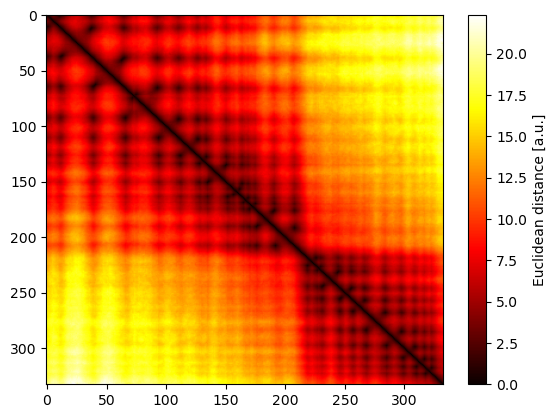

In [32]:
visualize_dmap(np.median(hox_dmaps[:, :, :100], 2))

In [24]:
dmaps_flat = [generate_flatten_distance_map(hox_polys[:, :, i]) for i in range(hox_polys.shape[2])]

In [19]:
observation_class_list = []
for j in range(53):
    for i in range(100):
        observation_class_list.append(j)

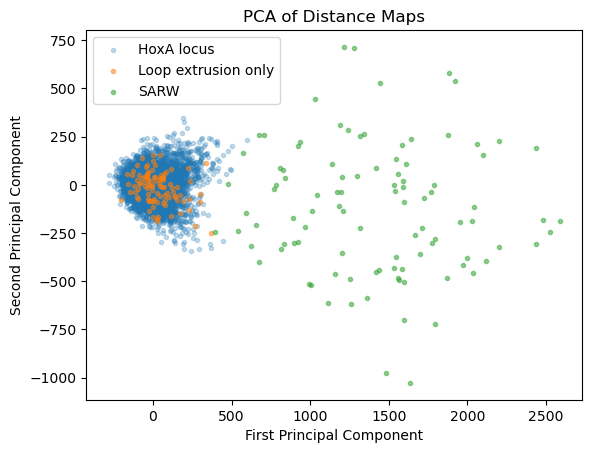

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot the heterogeneity of the structures from different simulations
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dmaps_flat)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

le_flat = []
for i in range(le_polys.shape[2]):
    le_flat.append(generate_flatten_distance_map(le_polys[:, :, i]))
    
sarw_flat = []
for i in range(sarw_polys.shape[2]):
    sarw_flat.append(generate_flatten_distance_map(sarw_polys[:, :, i]))

le_scaled = scaler.transform(le_flat)
le_pca = pca.transform(le_scaled)

sarw_scaled = scaler.transform(sarw_flat)
sarw_pca = pca.transform(sarw_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.',  alpha=0.25, label='HoxA locus')
plt.scatter(le_pca [:, 0], le_pca[:, 1], marker='.',alpha=0.5, label='Loop extrusion only')
plt.scatter(sarw_pca[:, 0], sarw_pca[:, 1], marker='.', alpha=0.5, label='SARW')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Distance Maps')
plt.legend()
plt.show()
plt.savefig(save_folder + 'PCA_dmaps.png', dpi=300)

In [14]:
bond_length = []
for i_dmap in range(hox_dmaps.shape[2]):
    bond_length.extend(np.diagonal(hox_dmaps[:, :, i_dmap], 1))
    
bond_length = np.array(bond_length)

In [44]:
num_models = 52
num_dmaps = 100

num_monomers = 333
mean_bond_length = bond_length.mean()
std_bond_length = np.std(bond_length)

gaussian_noise_std = 1
measurement_error = gaussian_noise_std

num_observation_list = [num_dmaps for i in range(num_models)]
observations_flatten = dmaps_flat
num_probes = num_monomers


In [21]:
hox_dmap = np.median(hox_dmaps, 2)
hox_dmap_flat = hox_dmap.flatten()

In [43]:
init_model[0].shape

(110889,)

In [22]:
init_model = [le_dmaps[:, :, m].flatten() for m in range(le_dmaps.shape[2])]

In [23]:
init_model.sort(key=lambda x: np.sum((x - hox_dmap_flat)**2))

In [47]:
@jax.jit
def generate_posterior_parallelize(templates_flatten, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """ 
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    @jax.jit
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)/1e3
        val += logprior(t, num_probes)/1e3
        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha)) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
        return val 
    
    @jax.jit
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

@jax.jit
def structure_neg_objective_parallelize(templates):
    """
    """ 
    # jax.debug.print("{x}", x=observations_flatten.shape)
    template_weights = num_observation_list
    neg_posterior = -generate_posterior_parallelize(templates, observations_flatten, template_weights, weight_renormalization=1)
    # jax.debug.print("{x}", x=neg_posterior)
    return neg_posterior


In [39]:
optimization_res_dir = '/mnt/home/tudomlumleart/ceph/02_OptimizationResult/20240610_PG_NN_sim2/'

In [40]:
import gc
gc.collect()

23361

In [46]:
gc.collect()
torch.cuda.empty_cache()

if not os.path.exists(optimization_res_dir):
    os.mkdir(optimization_res_dir)
    
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative

for i in tqdm(range(1, 10)):
    pg = ProjectedGradient(fun=structure_neg_objective_parallelize, 
                       projection=projection_non_negative, 
                       implicit_diff=False, 
                       verbose=False, jit=True)
    pg_sol = pg.run(init_model[:i])
     
    pkl_fname = optimization_res_dir + 'PG_NN_sort_{}.pkl'.format(i)
    
    with open(pkl_fname, 'wb') as file:
        pickle.dump(pg_sol, file)
    
    del pg
    del pg_sol 
    gc.collect()
    torch.cuda.empty_cache()
    

  0%|          | 0/9 [00:00<?, ?it/s]

2024-06-10 19:11:18.445156: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2410] Execution of replica 0 failed: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [44]:

optimization_res_dir = '/mnt/home/tudomlumleart/ceph/02_OptimizationResult/20240610_LBFGS/'

In [47]:
import gc
gc.collect()
torch.cuda.empty_cache()

from jaxopt import LBFGS


for i in tqdm(range(1, 20)):
    pg = LBFGS(fun=structure_neg_objective_parallelize, 
            linesearch='backtracking',
                        implicit_diff=True, 
                        verbose=False, jit=True)

    pg_sol = pg.run(init_model[:i])
    
    pkl_fname = optimization_res_dir + 'LBFGS_sort_{}.pkl'.format(i)
    
    with open(pkl_fname, 'wb') as file:
        pickle.dump(pg_sol, file)
        
    torch.cuda.empty_cache()

  0%|          | 0/19 [00:00<?, ?it/s]

36678.438910223726
25444.000447347367
25443.997960127745
25443.99795154742
34994.6704279384
27219.309122183447
25449.998033057804
24679.02355172135
24151.040310472235
23979.319403959576
23772.766770604547
23714.188636019764
23688.99038725696
23681.263186086937
23679.030421678315
23662.3281904578
23667.17976278455
23670.43822046031
23672.663661203882
23674.220395192777
23675.338906413475
23676.163246054657
23676.784019535804
23677.259471667297
23677.6282414654
23677.91687747719
23678.144248234676
23678.324164052898
23678.46697575794
23678.580583405666
23678.67109777696
23678.743291370723
23678.80091706146
23678.846940206095
23678.883711882638
23678.91310063159
23678.936594041254
23678.9553778752
23678.970398156544
23678.982410134056
23678.99201704647
23678.99970089287
23679.00584690534
23679.010763040493
23679.01469552009
23679.01755255607
23679.016974637
23679.01651464606
23679.016148153645
23679.015855919923
23679.015622747473
23679.015436602807
23679.01528793879
23679.015169168666
23

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

from jaxopt import LBFGS

pg_list = []
for i in tqdm(range(1, 11)):
    pg = LBFGS(fun=structure_neg_objective_parallelize, 
            linesearch='backtracking',
                        implicit_diff=True, 
                        verbose=False, jit=True)

    pg_sol = pg.run(init_model[:i])
    pg_list.append(pg_sol)
    torch.cuda.empty_cache()

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


36678.438910223726
25444.000447347367
25443.99796012775
25443.99795154742
34994.6704279384
27219.30912218345
25449.998033057804
24679.023551721355
24151.040310472235
23979.319403959576
23772.766770604547
23714.188636019764
23688.99038725696
23681.263186086937
23679.030421678315
23662.3281904578
23667.17976278455
23670.43822046031
23672.663661203886
23674.220395192777
23675.338906413475
23676.163246054657
23676.784019535808
23677.259471667297
23677.6282414654
23677.91687747719
23678.144248234676
23678.324164052898
23678.466975757936
23678.58058340567
23678.67109777696
23678.743291370723
23678.80091706146
23678.846940206095
23678.883711882638
23678.91310063159
23678.936594041254
23678.9553778752
23678.970398156544
23678.982410134056
23678.99201704647
23678.99970089287
23679.005846905337
23679.010763040493
23679.01469552009
23679.01755255607
23679.016974637
23679.016514646057
23679.016148153645
23679.015855919923
23679.015622747473
23679.015436602807
23679.01528793879
23679.015169168666
2

In [14]:
import re
def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf') 

sorted(os.listdir(optimization_res_dir), key=extract_number)

['PG_NN_sort_1.pkl',
 'PG_NN_sort_2.pkl',
 'PG_NN_sort_3.pkl',
 'PG_NN_sort_4.pkl',
 'PG_NN_sort_5.pkl',
 'PG_NN_sort_6.pkl',
 'PG_NN_sort_7.pkl',
 'PG_NN_sort_8.pkl',
 'PG_NN_sort_9.pkl',
 'PG_NN_sort_10.pkl',
 'PG_NN_sort_11.pkl',
 'PG_NN_sort_12.pkl',
 'PG_NN_sort_13.pkl',
 'PG_NN_sort_14.pkl',
 'PG_NN_sort_15.pkl',
 'PG_NN_sort_16.pkl',
 'PG_NN_sort_17.pkl',
 'PG_NN_sort_18.pkl',
 'PG_NN_sort_19.pkl',
 'PG_NN_sort_20.pkl',
 'PG_NN_sort_21.pkl',
 'PG_NN_sort_22.pkl',
 'PG_NN_sort_23.pkl',
 'PG_NN_sort_24.pkl',
 'PG_NN_sort_25.pkl',
 'PG_NN_sort_26.pkl',
 'PG_NN_sort_27.pkl',
 'PG_NN_sort_28.pkl',
 'PG_NN_sort_29.pkl',
 'PG_NN_sort_30.pkl',
 'PG_NN_sort_31.pkl',
 'PG_NN_sort_32.pkl',
 'PG_NN_sort_33.pkl',
 'PG_NN_sort_34.pkl',
 'PG_NN_sort_35.pkl',
 'PG_NN_sort_36.pkl',
 'PG_NN_sort_37.pkl',
 'PG_NN_sort_38.pkl',
 'PG_NN_sort_39.pkl',
 'PG_NN_sort_40.pkl',
 'PG_NN_sort_41.pkl',
 'PG_NN_sort_42.pkl',
 'PG_NN_sort_43.pkl',
 'PG_NN_sort_44.pkl',
 'PG_NN_sort_45.pkl',
 'PG_NN_sort_46.pkl

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [15]:
def load_optimization_result(optimization_res_dir):
    def extract_number(file_name):
        match = re.search(r'\d+', file_name)
        return int(match.group()) if match else float('inf')  # Return a high number if no number is found

    items = os.listdir(optimization_res_dir)
    sorted_items = sorted(items, key=extract_number)
    
    optim_params_list = []
    for item in sorted_items: 
        if item[-4:] == '.pkl':
            with open(optimization_res_dir + item, 'rb') as file:
                optim_res = pickle.load(file)
                optim_params_list.append(optim_res.params)
                
    return optim_params_list
        

In [16]:
pg_list = load_optimization_result(optimization_res_dir)

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [17]:
posterior_list = []
for optim in pg_list:
    posterior_list.append(structure_neg_objective_parallelize(optim))
posterior_list = -np.array(posterior_list)

In [18]:
posterior_list

array([-25443.99795818, -23390.00710291, -22209.0146998 , -20922.75527015,
       -20294.76858945, -19484.8396431 , -18622.58019019, -18117.19815049,
       -18011.96322852, -17212.00050453, -17106.94442499, -17211.0465134 ,
       -17095.66942965, -16813.72128663,             nan,             nan,
                   nan, -16498.60018422, -16383.05075649, -16327.32839157,
       -16162.15308422, -16068.30488266, -16063.80899415, -16067.44852819,
       -15953.36693712, -15913.51484575, -15870.36845293, -15843.69968563,
       -15799.54772844, -15738.47392259, -15635.77884411, -15649.19105773,
       -15759.29452171, -15627.02358731,             nan,             nan,
                   nan,             nan,             nan, -15427.36863759,
       -15416.90730796,             nan,             nan,             nan,
       -15281.82015781,             nan,             nan,             nan,
                   nan])

Text(0.5, 0, 'Number of models')

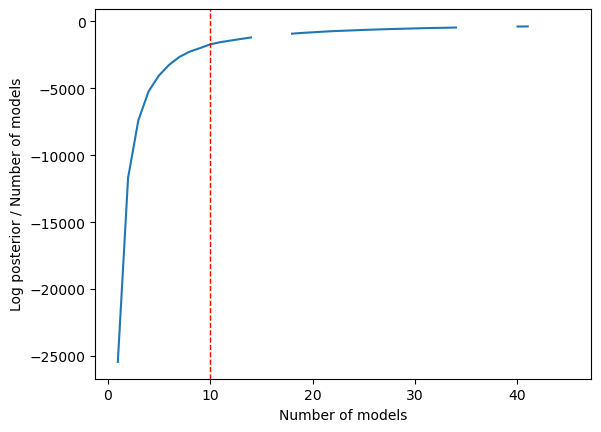

In [19]:
posterior_list_norm = posterior_list / np.arange(1, len(posterior_list)+1)

plt.plot(np.arange(1, len(posterior_list)+1), posterior_list_norm)
plt.axvline(x=10, color='r', linestyle='--', linewidth=1)
plt.ylabel('Log posterior / Number of models')
plt.xlabel('Number of models')


Text(0.5, 0, 'Number of models')

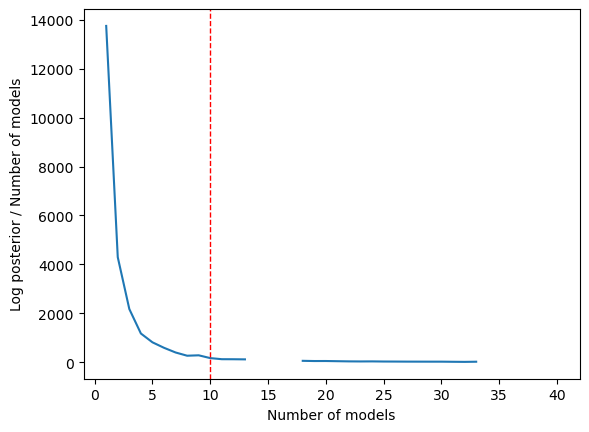

In [25]:
plt.plot(np.arange(1, len(posterior_list)), np.diff(posterior_list_norm))
plt.axvline(x=10, color='r', linestyle='--', linewidth=1)
plt.ylabel('Log posterior / Number of models')
plt.xlabel('Number of models')


Text(0.5, 0, 'Number of models')

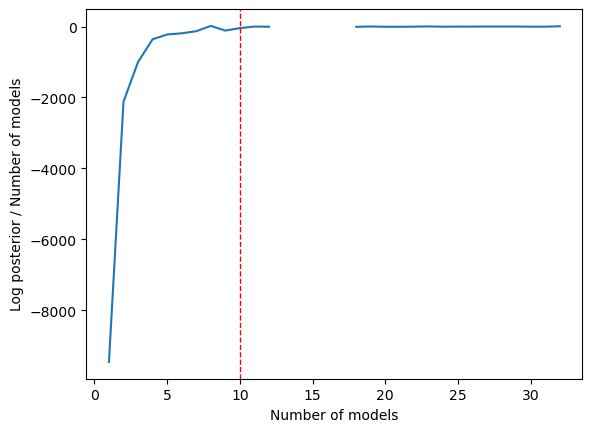

In [27]:
plt.plot(np.arange(1, len(posterior_list)-1), np.diff(posterior_list_norm, 2))
plt.axvline(x=10, color='r', linestyle='--', linewidth=1)
plt.ylabel('Log posterior / Number of models')
plt.xlabel('Number of models')

In [88]:
# This loss function depends so much on the number of model 

def loss_function(predicted_dmap_flat, template_dmap_flat):
    l = 0
    for p_dmap in predicted_dmap_flat:
        for t_dmap in predicted_dmap_flat:
            l += np.mean((p_dmap - t_dmap)**2)
    return l 

In [79]:
dmaps_flat = np.array(dmaps_flat)

In [89]:
template_dmap_flat = []
for m in range(10):
    template_dmap_flat.append(dmaps_flat[m*100:(m+1)*100, :].mean(axis=0))

In [90]:
loss_function(pg_list[10], template_dmap_flat)

Array(394.87478659, dtype=float64)

In [93]:
loss_list = []
for i in tqdm(range(20)):
    loss_list.append(loss_function(pg_list[i], template_dmap_flat))
loss_list = np.array(loss_list)

  0%|          | 0/20 [00:00<?, ?it/s]

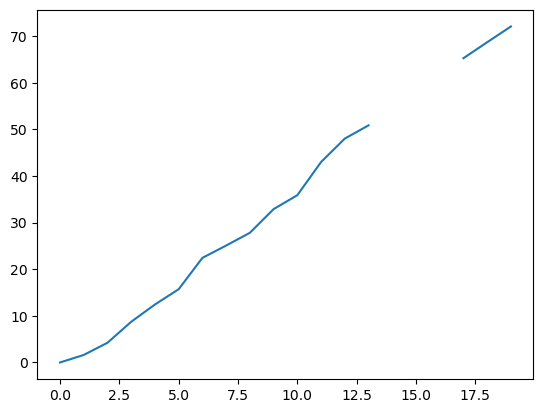

In [94]:
plt.plot(loss_list / np.arange(1, 21))

In [63]:
num_models = 10

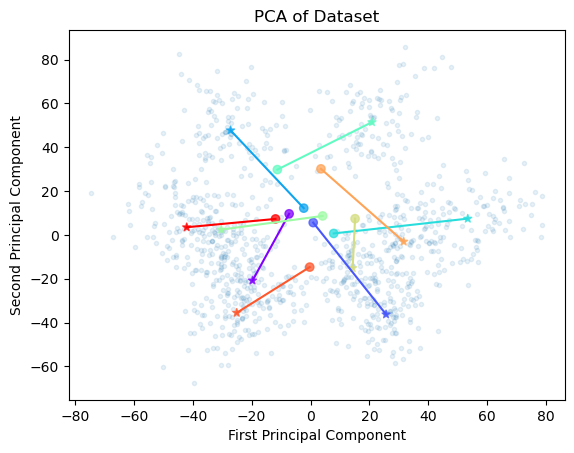

In [64]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('rainbow', num_models)
colors = cmap(np.linspace(0, 1, num_models))


# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dmaps_flat)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

init_model_scaled = scaler.transform(init_model[:num_models])
init_model_pca = pca.transform(init_model_scaled)

sol_scaled = scaler.transform(pg_list[num_models-1])
sol_pca = pca.transform(sol_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', alpha=0.1)
plt.scatter(init_model_pca[:, 0], init_model_pca[:, 1], marker='o', color=colors, alpha=0.75)
plt.scatter(sol_pca[:, 0], sol_pca[:, 1], marker='*', color=colors, alpha=0.75)

for i in range(num_models):
    plt.plot(np.concatenate([[init_model_pca[i, 0], sol_pca[i, 0]]]), np.concatenate([[init_model_pca[i, 1], sol_pca[i, 1]]]), color=colors[i])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

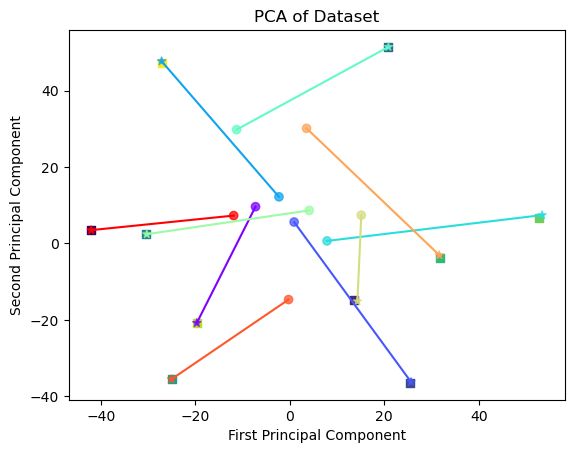

In [74]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('rainbow', num_models)
colors = cmap(np.linspace(0, 1, num_models))


cmap_model = plt.get_cmap('viridis', 10)
colors_model = cmap_model(np.linspace(0, 1, 10))

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dmaps_flat)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

init_model_scaled = scaler.transform(init_model[:num_models])
init_model_pca = pca.transform(init_model_scaled)

sol_scaled = scaler.transform(pg_list[num_models-1])
sol_pca = pca.transform(sol_scaled)

# Visualize results
for m in range(10):
    plt.scatter(X_pca[m*100:(m+1)*100, 0].mean(), X_pca[m*100:(m+1)*100, 1].mean(), marker='s', alpha=1, color=colors_model[m])
plt.scatter(init_model_pca[:, 0], init_model_pca[:, 1], marker='o', color=colors, alpha=0.75)
plt.scatter(sol_pca[:, 0], sol_pca[:, 1], marker='*', color=colors, alpha=0.75)

for i in range(num_models):
    plt.plot(np.concatenate([[init_model_pca[i, 0], sol_pca[i, 0]]]), np.concatenate([[init_model_pca[i, 1], sol_pca[i, 1]]]), color=colors[i])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [66]:
pg_sol.state

ProxGradState(iter_num=Array(14, dtype=int64, weak_type=True), stepsize=Array(16., dtype=float64), error=Array(0.00014488, dtype=float64), aux=None, velocity=[Array([0.        , 0.99975342, 1.70566788, ..., 1.88154112, 1.05896202,
       0.        ], dtype=float64), Array([0.        , 0.98576323, 1.73893948, ..., 1.71664574, 1.00584998,
       0.        ], dtype=float64), Array([0.        , 1.02975744, 1.91752475, ..., 1.70390826, 0.99503798,
       0.        ], dtype=float64), Array([0.        , 1.02503712, 1.88108915, ..., 1.46198477, 0.9505792 ,
       0.        ], dtype=float64), Array([0.        , 1.00279624, 1.99784712, ..., 1.9400244 , 0.97882496,
       0.        ], dtype=float64), Array([0.        , 1.00722378, 1.91619269, ..., 1.8349383 , 0.98595226,
       0.        ], dtype=float64), Array([0.        , 1.00935908, 1.72203514, ..., 1.90601449, 0.98208752,
       0.        ], dtype=float64), Array([0.        , 0.98737016, 1.9495902 , ..., 1.98569805, 1.02849503,
       0.    

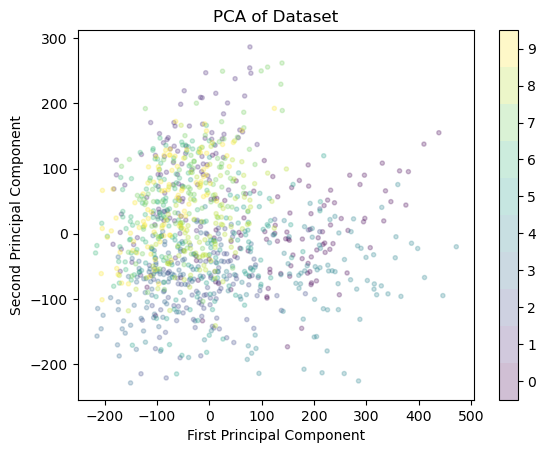

In [37]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dmaps_flat[:1000])

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=observation_class_list[:1000], alpha=0.25)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [50]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dmaps_flat)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=observation_class_list, alpha=0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

Array([ True, False, False, ..., False, False,  True], dtype=bool)

In [69]:
np.min(pg_sol[0])

-1331.062104915386

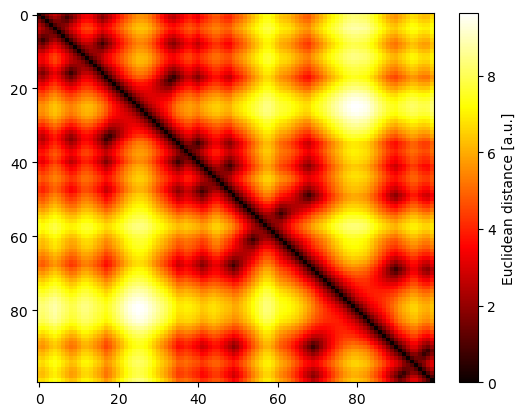

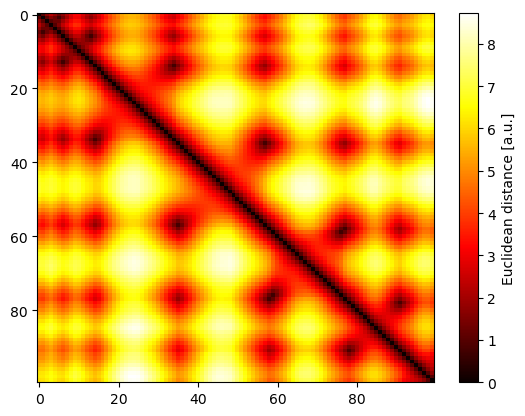

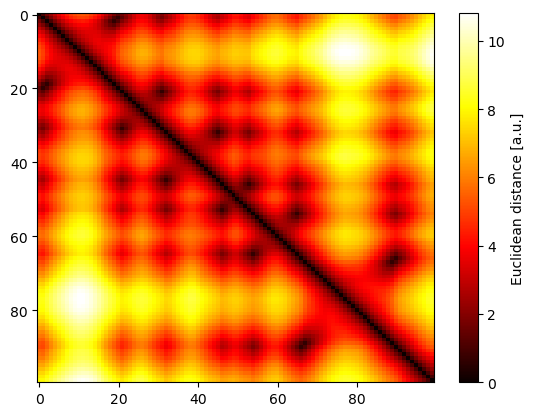

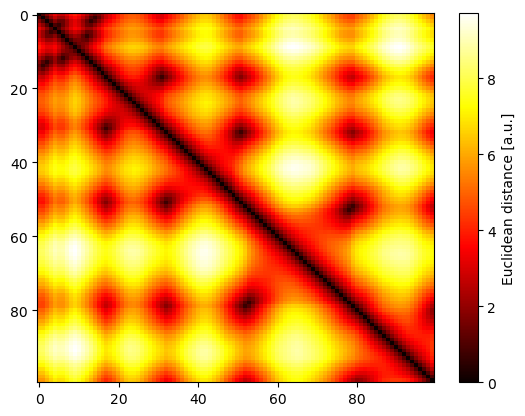

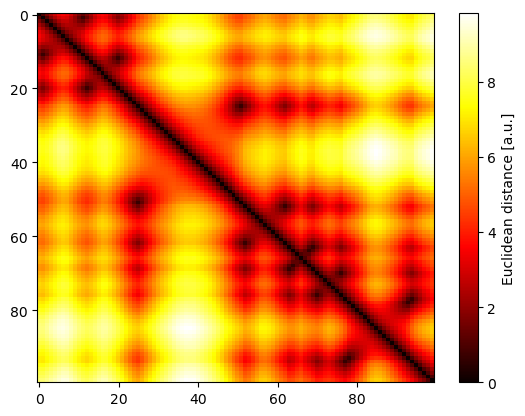

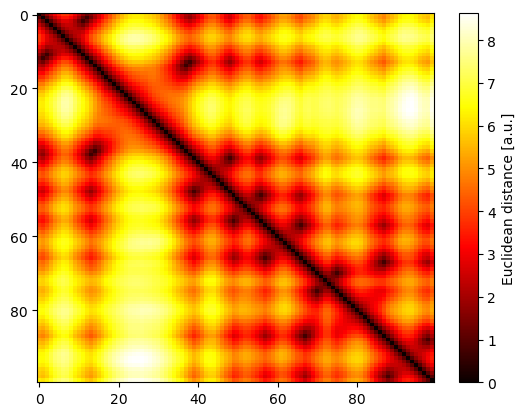

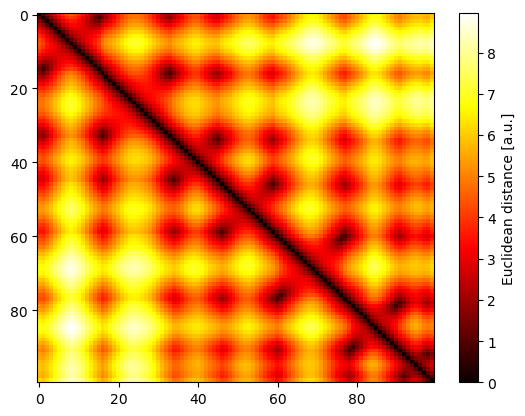

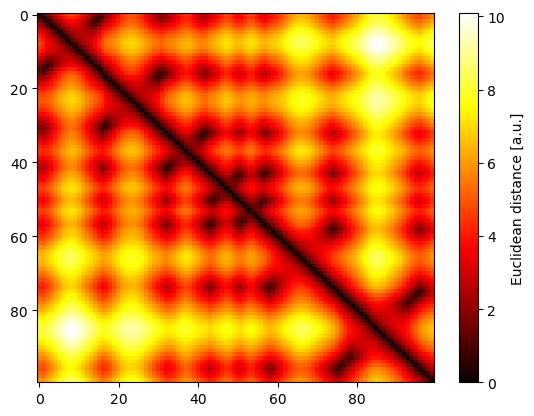

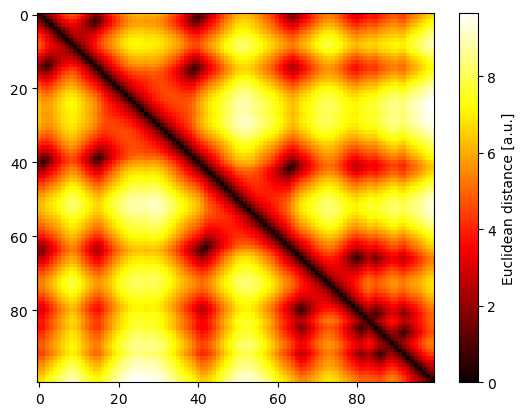

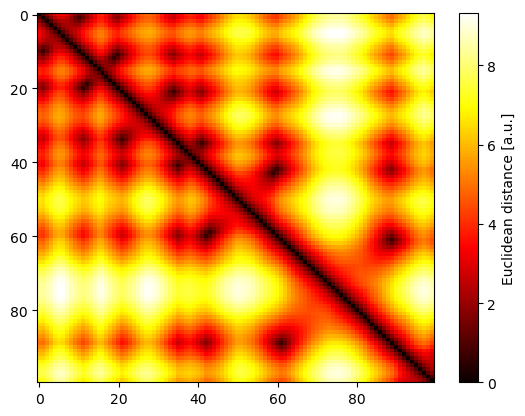

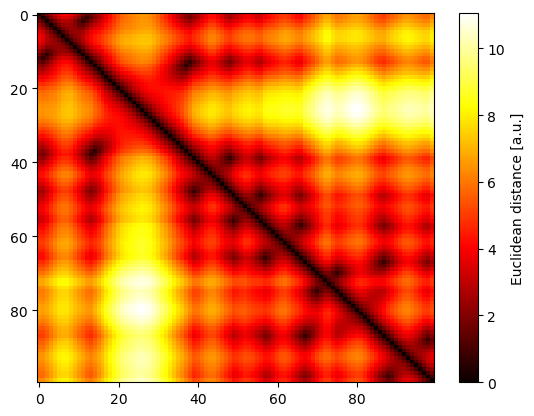

In [72]:
for sol in pg_list[10]:
    sol = np.array(sol)
    visualize_dmap(sol.reshape(100, 100))

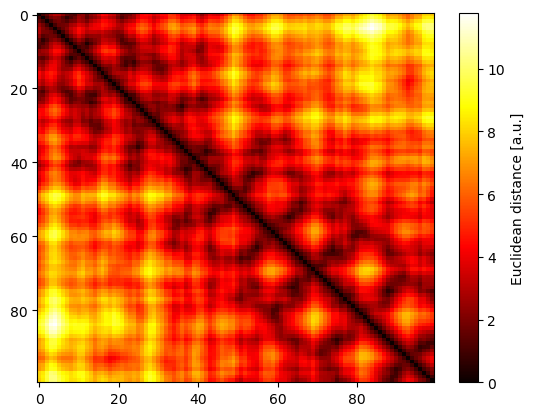

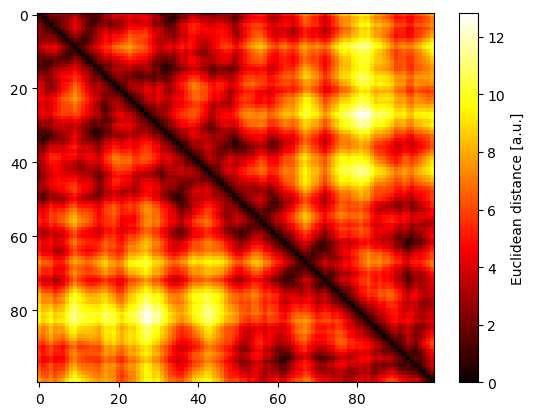

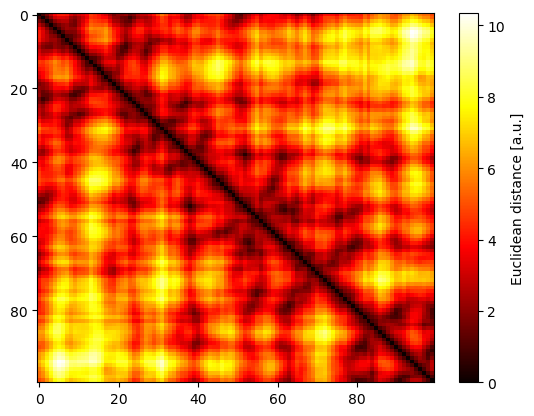

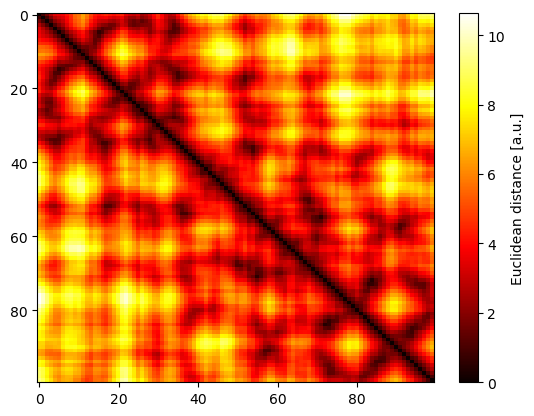

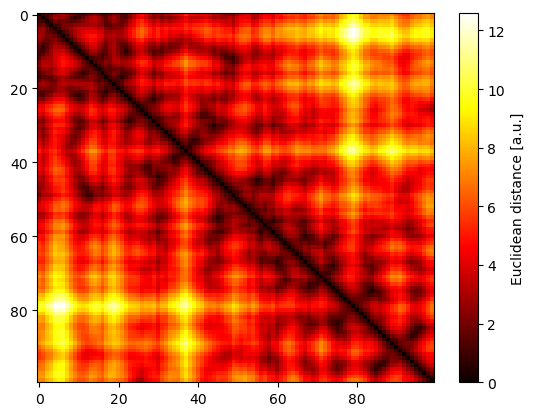

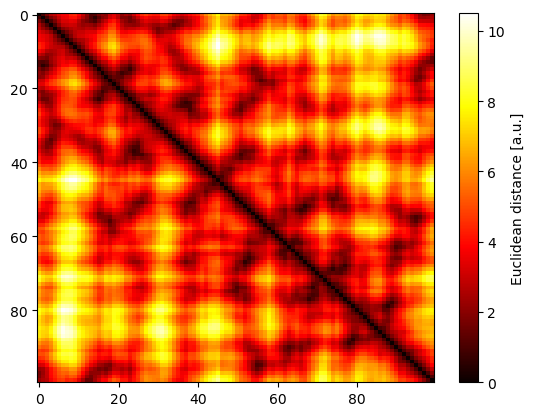

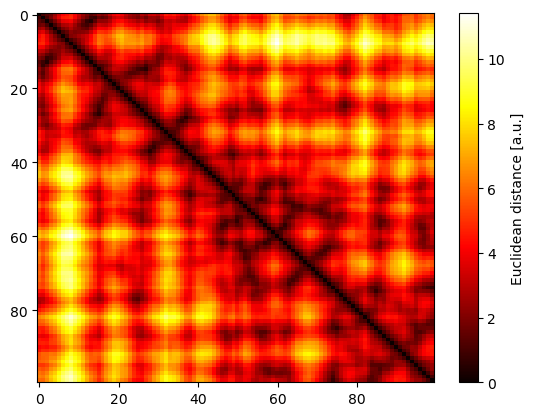

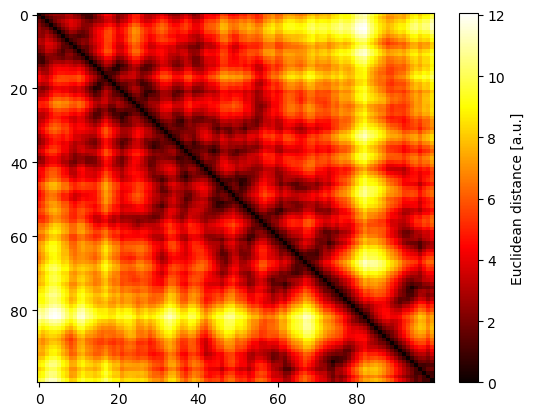

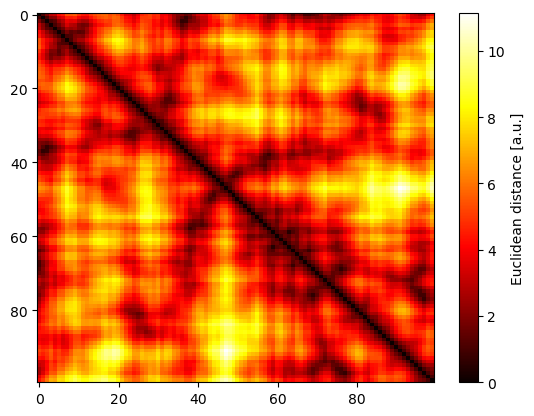

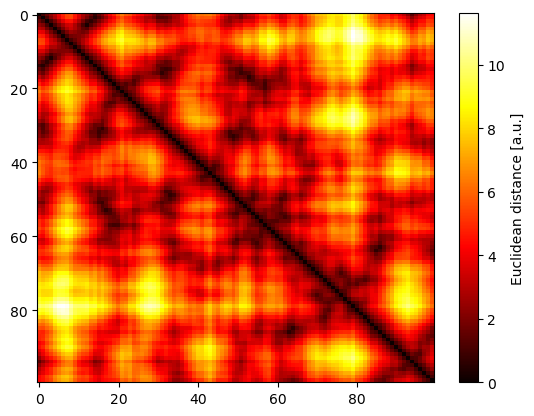

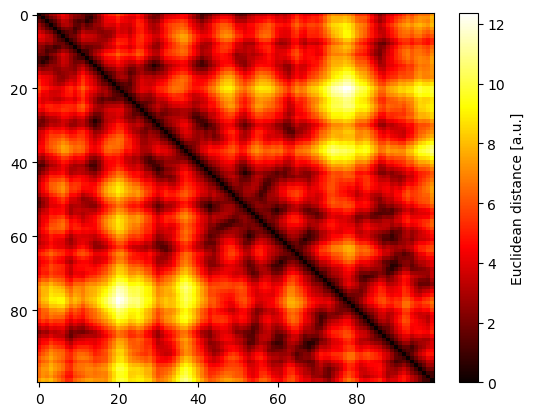

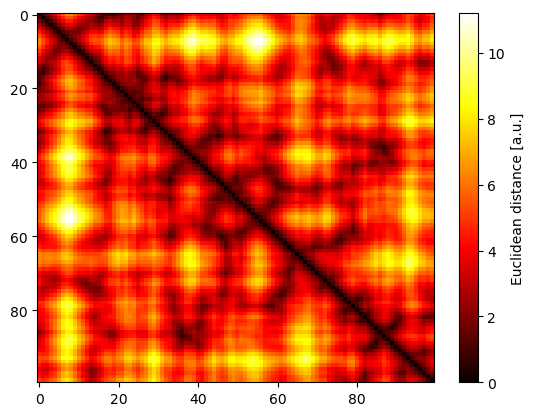

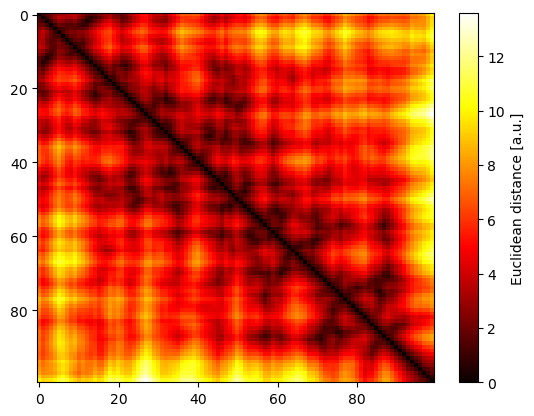

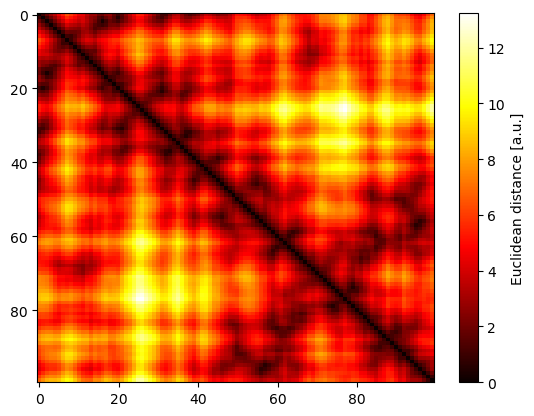

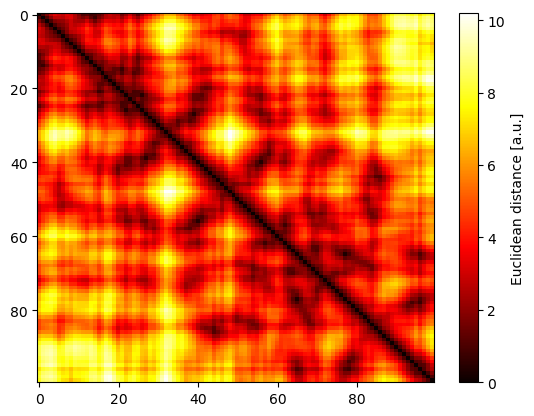

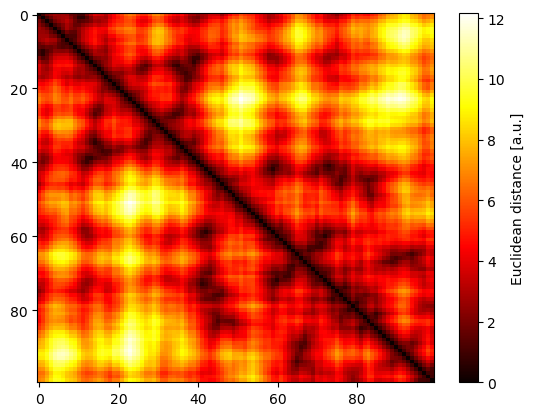

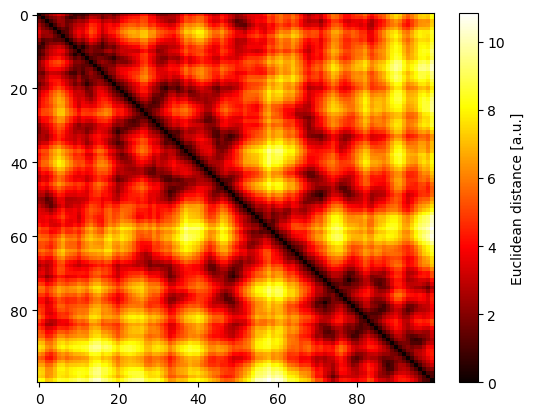

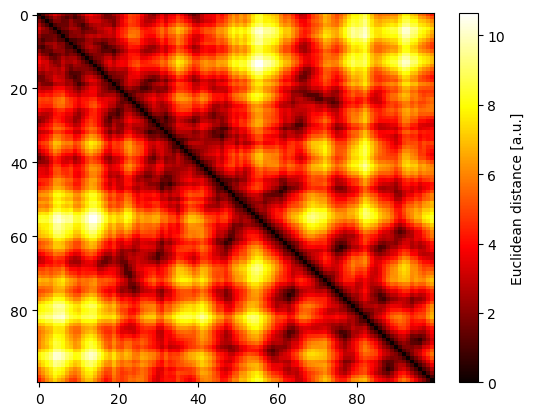

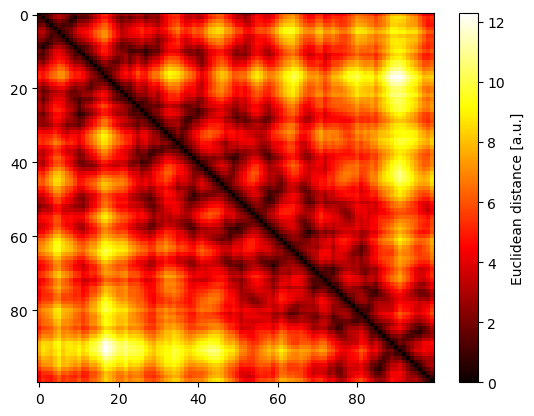

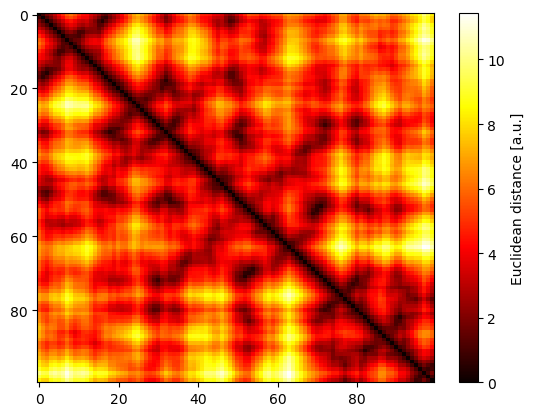

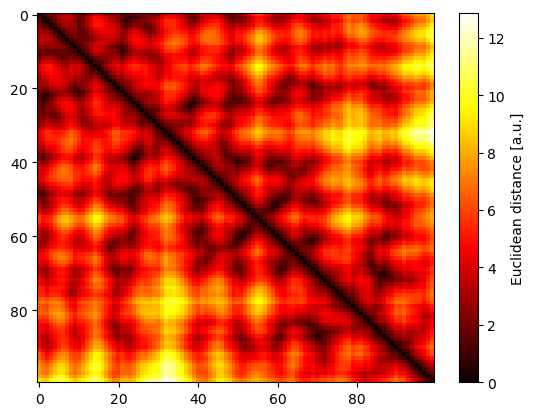

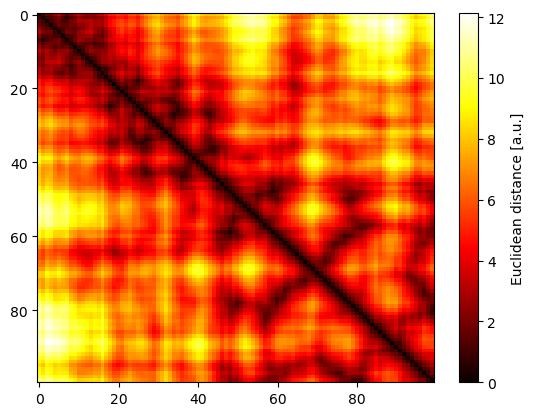

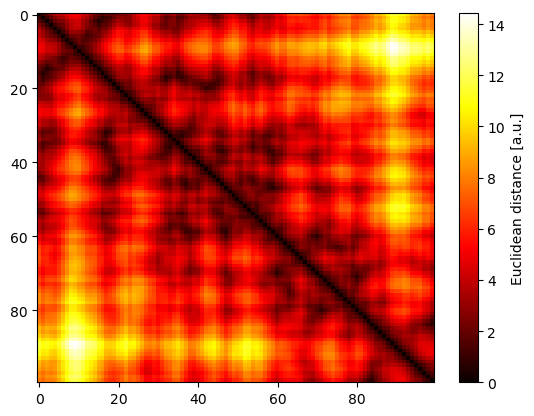

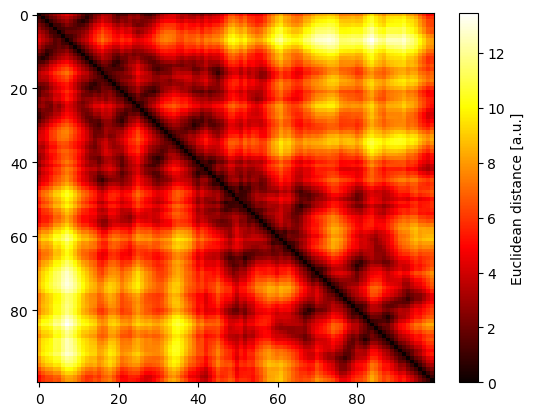

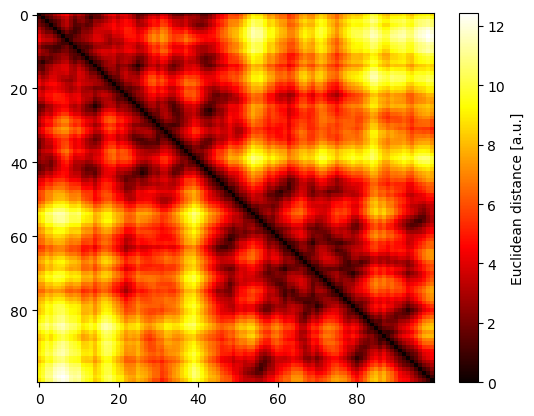

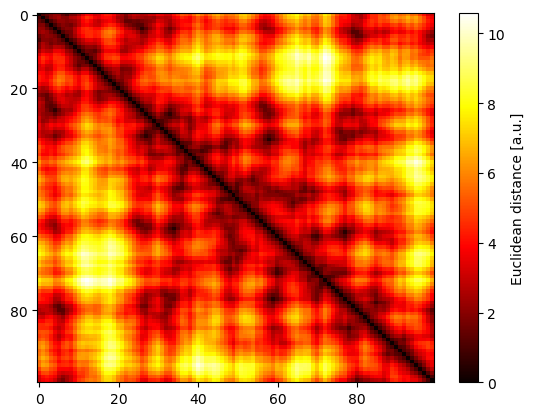

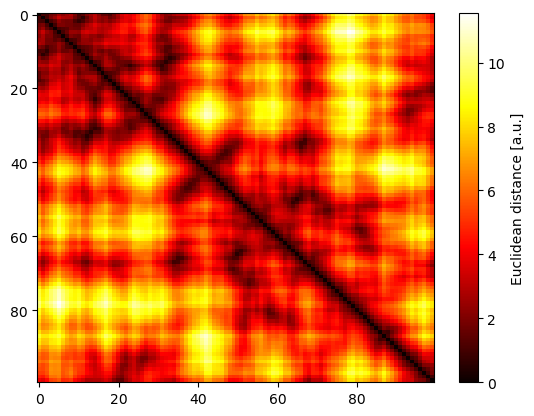

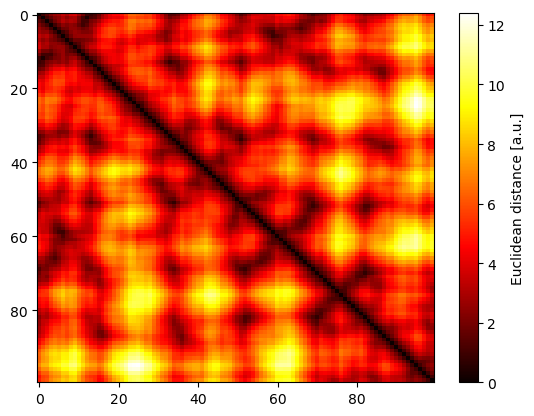

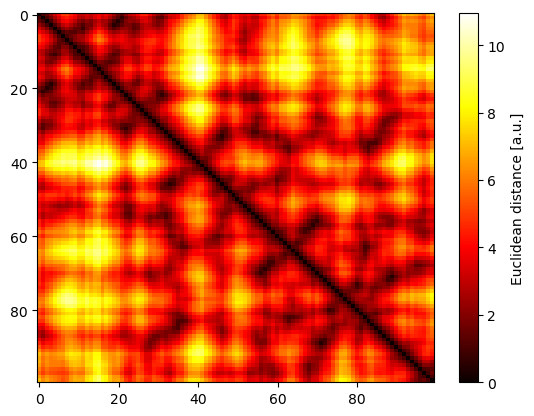

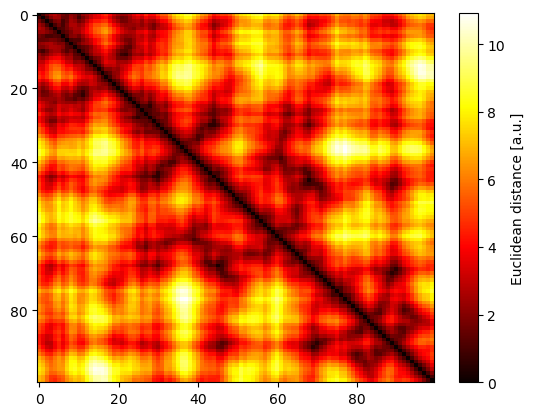

KeyboardInterrupt: 

In [95]:
for m in init_model:
    visualize_dmap(m.reshape(100, 100))

In [27]:
LEF_file = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA/LEF_info/LEFPos_template0.h5'
LEF_data = h5py.File(LEF_file, 'r') 
LEFPos = LEF_data['positions']

In [29]:
LEFPos[-1, :, :]

array([[192, 208],
       [135, 151],
       [310, 317],
       [231, 245],
       [ 12,  38],
       [128, 134],
       [176, 191],
       [268, 284],
       [257, 267],
       [227, 230],
       [  1,  11],
       [152, 164],
       [ 66,  93],
       [165, 169],
       [299, 309],
       [112, 127],
       [219, 226],
       [318, 323],
       [170, 175],
       [246, 256],
       [232, 244],
       [ 94, 111],
       [ 39,  65],
       [ 40,  64],
       [136, 150],
       [ 41,  63],
       [285, 298],
       [247, 255],
       [177, 190],
       [ 13,  37],
       [228, 229],
       [157, 162],
       [ 72,  75]], dtype=int32)

In [30]:
LEF_file = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA/LEF_info/LEFPos_template1.h5'
LEF_data = h5py.File(LEF_file, 'r') 
LEFPos = LEF_data['positions']

LEFPos[-1, :, :]

array([[167, 172],
       [134, 140],
       [141, 152],
       [259, 277],
       [124, 133],
       [173, 191],
       [ 75,  80],
       [ 57,  62],
       [208, 234],
       [ 94, 112],
       [ 66,  69],
       [278, 331],
       [  1,  19],
       [ 39,  56],
       [ 70,  74],
       [247, 258],
       [ 20,  38],
       [ 81,  93],
       [113, 116],
       [117, 123],
       [ 63,  65],
       [153, 163],
       [192, 207],
       [164, 166],
       [235, 246],
       [174, 190],
       [175, 189],
       [ 21,  37],
       [ 95, 111],
       [209, 233],
       [193, 206],
       [176, 188],
       [279, 296]], dtype=int32)

In [ ]:
@jax.jit
def generate_posterior_parallelize(templates_flatten, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """ 
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    @jax.jit
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)
        jax.debug.print('{x}', x=val)
        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    @jax.jit
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

@jax.jit
def structure_neg_objective_parallelize(templates):
    """
    """ 
    # jax.debug.print("{x}", x=observations_flatten.shape)
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)

In [4]:
structure_neg_objective_parallelize(init_model)

-5431420416.0
-1727518464.0
-4203162112.0
-1797054208.0
-3569559552.0
-859715904.0
-1874313216.0
-1887907328.0
-2098303360.0
-1258000256.0
-5434994688.0
-1729173760.0
-4206880256.0
-1799185664.0
-3572435200.0
-861716736.0
-1876514560.0
-1889741568.0
-2100822016.0
-1260513280.0
-5419546624.0
-1721960448.0
-4193727488.0
-1792700928.0
-3560478208.0
-856618752.0
-1868885632.0
-1883534080.0
-2092324608.0
-1253410304.0
-5425749504.0
-1725550592.0
-4198884608.0
-1796633472.0
-3565366272.0
-859259136.0
-1872685184.0
-1886825728.0
-2095890176.0
-1256804608.0
-5431688704.0
-1727254784.0
-4204024320.0
-1797518080.0
-3569822976.0
-860732800.0
-1874349952.0
-1887538176.0
-2098748544.0
-1259044096.0
-5427557376.0
-1725499520.0
-4201147392.0
-1797024896.0
-3566184192.0
-859710784.0
-1873150848.0
-1886315776.0
-2097029120.0
-1257788672.0
-5434230784.0
-1729611008.0
-4206488320.0
-1798942592.0
-3571673856.0
-861454080.0
-1876954624.0
-1890412928.0
-2100578304.0
-1259915776.0
-5435842048.0
-1729660672.0

Array(8.595655e+10, dtype=float32)

In [2]:
polymer_directory = r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme'

In [74]:
save_folder = r'/mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240604/'

In [3]:
items = os.listdir(polymer_directory)
# Filter out the items that are not directories
folders = [item for item in items if os.path.isdir(os.path.join(polymer_directory, item))]
polymer_folders = [os.path.join(polymer_directory, f) for f in folders]

In [4]:
def load_polymer_hdf5(polymer_directory):
    URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
    [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
    num_polymers = len(URIs)
    polys = np.full((num_monomers, 3, num_polymers), np.nan)
    dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
    for iURI, URI in enumerate(URIs):
        data = polychrom.hdf5_format.load_URI(URI)
        xyz = data["pos"]
        polys[:, :, iURI] = xyz[:num_monomers, :]
        dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
    return polys, dmaps


In [5]:
polymer_folders.sort()

In [5]:
polymer_folders

['/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_6',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_8',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_7',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_3',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_4',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_9',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_dirCTCF_sticky_updatedScheme/template_1',
 '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_di

In [6]:
polys_list, dmaps_list = [], []
for f in polymer_folders:
    try:
        polys, dmaps = load_polymer_hdf5(f)
        polys_list.append(polys)
        dmaps_list.append(dmaps)
    except:
        continue

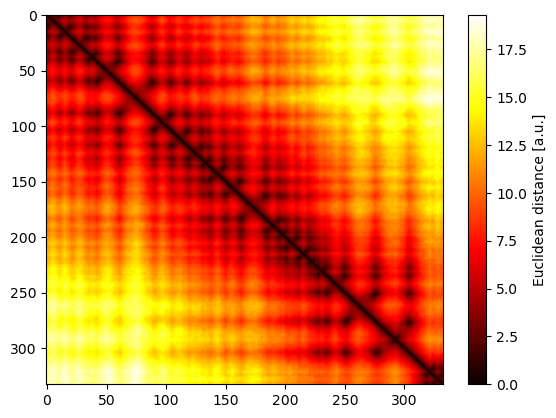

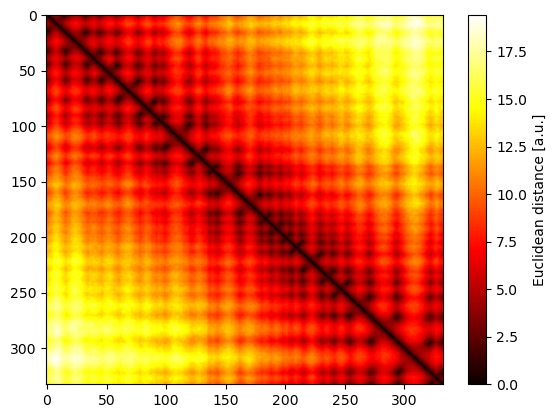

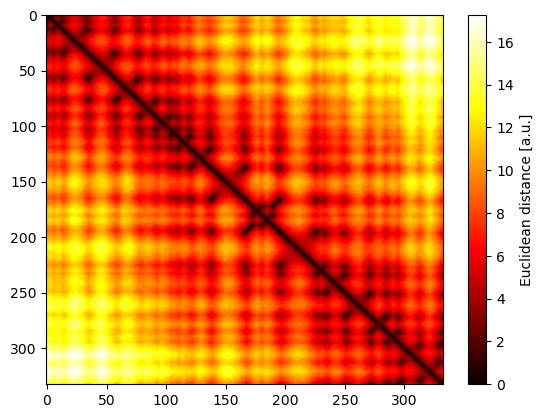

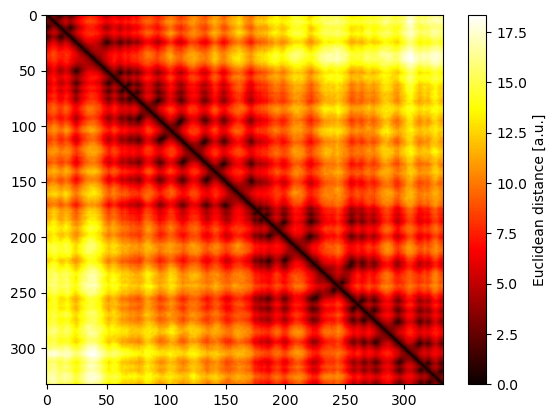

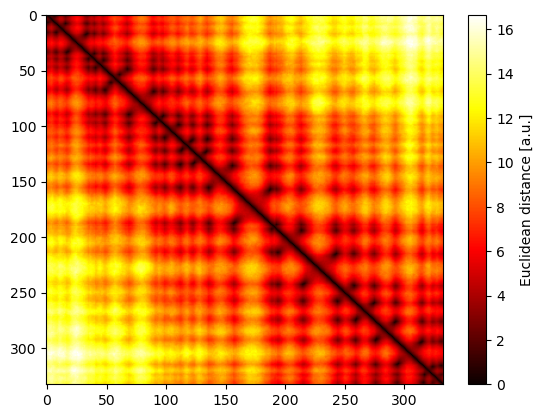

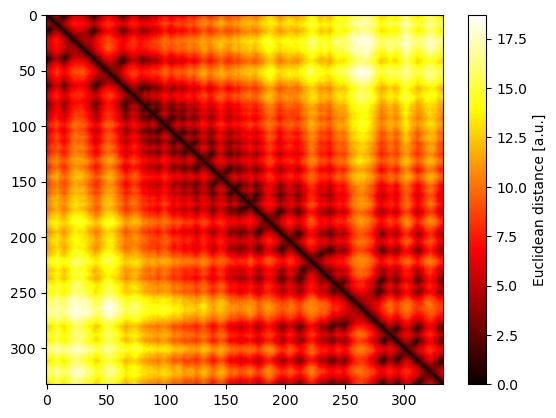

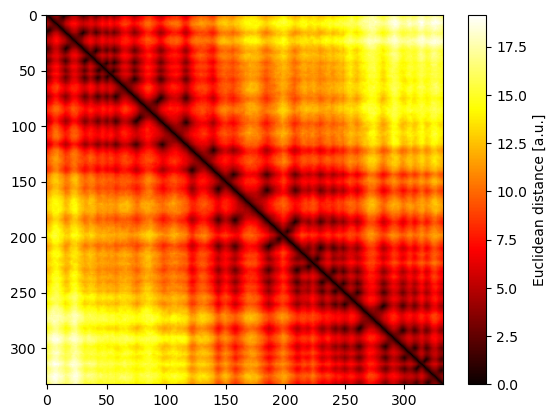

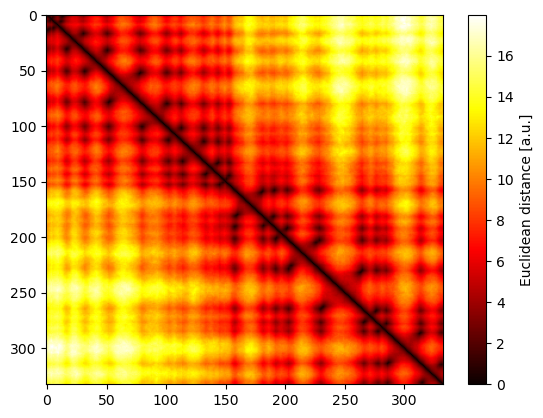

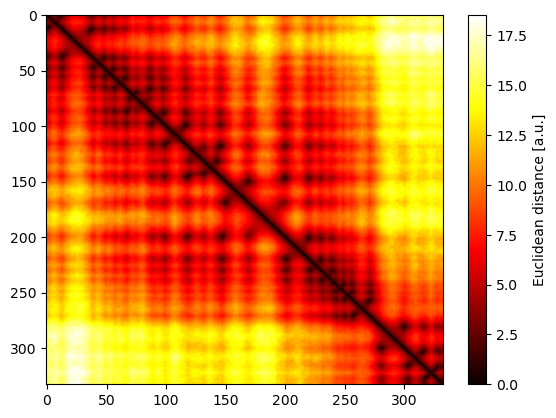

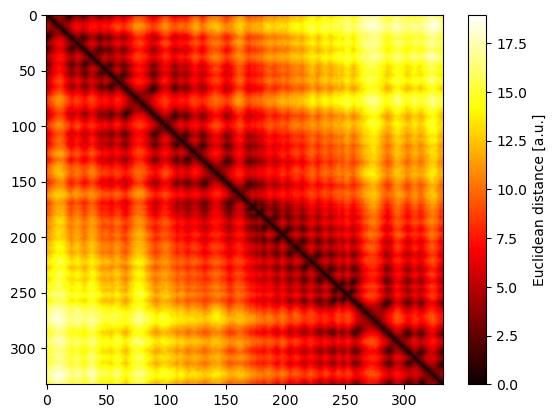

In [54]:
for dmap in dmaps_list:
    visualize_dmap(np.median(dmap, 2))

In [17]:
dmaps_flat = []
observation_class_list = []
for i, sample in enumerate(dmaps_list):
    _, _, num_dmaps = sample.shape
    for m in range(num_dmaps):
        dmaps_flat.append(sample[:, :, m].flatten())
        observation_class_list.append(i)
dmaps_flat = np.array(dmaps_flat)

NameError: name 'dmaps_list' is not defined

In [9]:
dmaps_flat.shape

(1000, 110889)

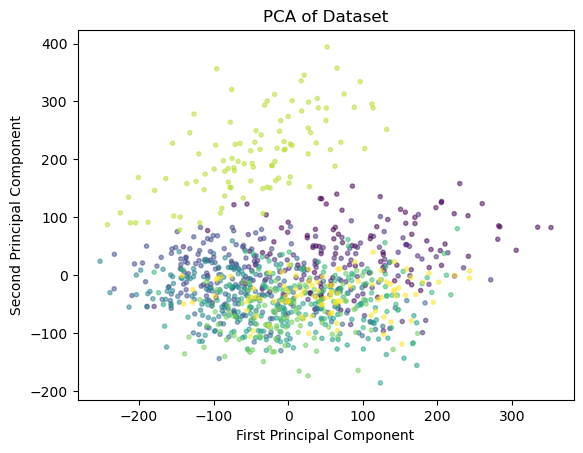

In [8]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dmaps_flat)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=observation_class_list, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [8]:
bond_length = []
bond_std = []
for i, sample in enumerate(dmaps_list):
    _, _, num_dmaps = sample.shape
    for m in range(num_dmaps):
        bond_length.append(sample[:, :, m].diagonal(1).mean())
        bond_std.append(sample[:, :, m].diagonal(1).std())
bond_length = np.array(bond_length)
bond_std = np.array(bond_std)

In [12]:
bond_length.mean()

1.0028848116251816

In [13]:
bond_std.mean()

0.038042311997396404

In [9]:
num_models = 10

num_monomers = 333
mean_bond_length = bond_length.mean()
std_bond_length = bond_std.mean()*2000

gaussian_noise_std = bond_std.mean()
measurement_error = gaussian_noise_std

init_model = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for m in range(num_models)]


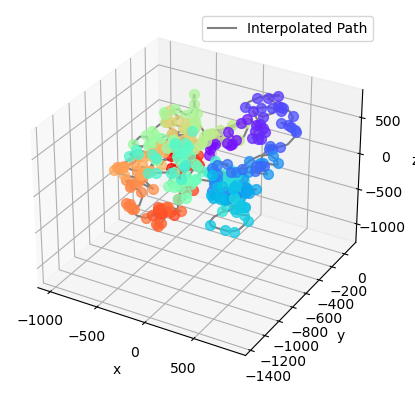

In [11]:
visualize_polymer(init_model[2])

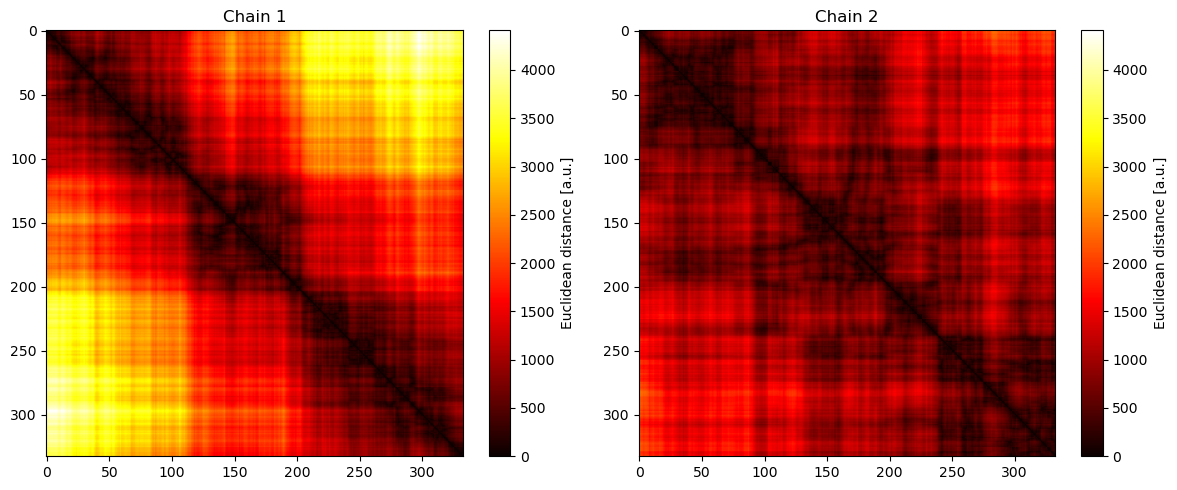

In [15]:
compare_distance_maps(init_model[0], init_model[2])

In [10]:
init_model = [generate_flatten_distance_map(m) for m in init_model]


In [11]:
num_observation_list = [100 for i in range(10)]
observations_flatten = dmaps_flat
num_probes = num_monomers

In [12]:
@jax.jit
def generate_posterior_parallelize(templates_flatten, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """ 
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    @jax.jit
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)
        jax.debug.print('{x}', x=val)
        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    @jax.jit
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

@jax.jit
def structure_neg_objective_parallelize(templates):
    """
    """ 
    # jax.debug.print("{x}", x=observations_flatten.shape)
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)
    

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [14]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative
import gc 

pg = ProjectedGradient(fun=structure_neg_objective_parallelize, 
                       projection=projection_non_negative, 
                       implicit_diff=True, 
                       verbose=True, jit=True)
pg_sol = pg.run(init_model)
torch.cuda.empty_cache()

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-06-06 12:02:53.854149: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update] Very slow compile?  If you want to file a bug, run wi

XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [22]:
pg_sol

OptStep(params=[Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)], state=ProxGradState(iter_num=Array(2, dtype=int32, weak_type=True), stepsize=Array(4., dtype=float32), error=Array(nan, dtype=float32), aux=None, velocity=[Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), A

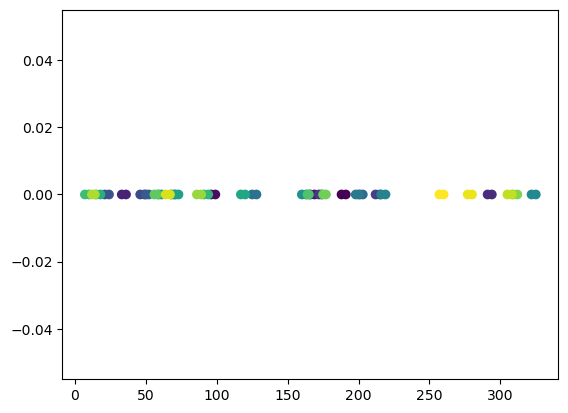

In [37]:
plt.scatter(t1, [0 for i in range(len(t1))], c=c1)

In [40]:
t_list = []
for t_ in range(34):
    t_list.append(lef_trajectory['positions'][t_, :, :].flatten())

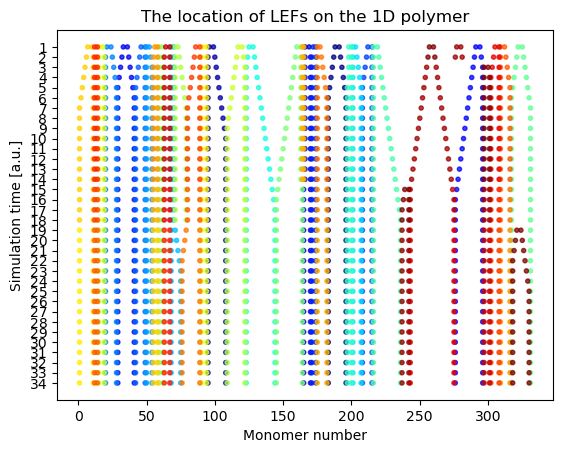

In [89]:
# Create a figure and an axis
fig, ax = plt.subplots()

for t_ in range(34):
    ax.scatter(t_list[t_], [34-t_ for i in range(len(t1))], c=c1, marker='.', cmap='jet', alpha=0.75)

yticks = np.arange(1, 35)
ax.set_yticks(yticks)
ax.set_yticklabels([34-t_ for t_ in range(34)])
plt.title('The location of LEFs on the 1D polymer')
plt.xlabel('Monomer number')
plt.ylabel('Simulation time [a.u.]')
plt.savefig(save_folder + 'LEF_1D_location.png', dpi=300)


In [63]:
t_list = []
for t_ in range(2000):
    t_list.append(lef_trajectory['positions'][t_, :, :].flatten())

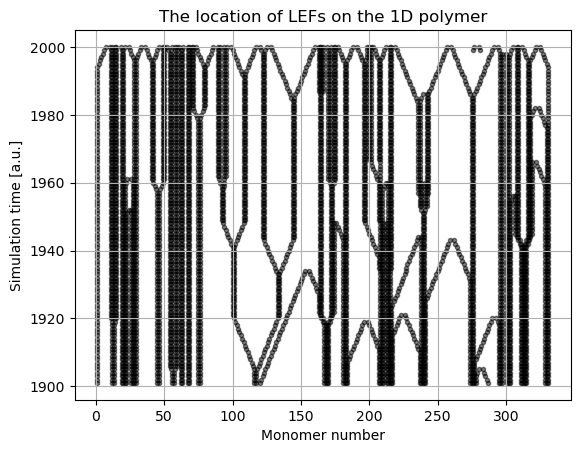

In [90]:
# Create a figure and an axis
fig, ax = plt.subplots()

for t_ in range(100):
    ax.scatter(t_list[t_], [2000-t_ for i in range(len(t1))], color='black', marker='.', alpha=0.5)
ax.grid()
# yticks = np.arange(1, 2001)
# ax.set_yticks(yticks)
# ax.set_yticklabels([2000-t_ for t_ in range(100)])
plt.title('The location of LEFs on the 1D polymer')
plt.xlabel('Monomer number')
plt.ylabel('Simulation time [a.u.]')
plt.savefig(save_folder + 'LEF_1D_location_zoomout.png', dpi=300)